In [1]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 665kB 8.2MB/s 
     |████████████████████████████████| 3.8MB 59.3MB/s 
     |████████████████████████████████| 1.1MB 19.6MB/s 
     |████████████████████████████████| 890kB 55.4MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/197-roBERTa_base/'

## Dependencies

In [5]:
import json, glob, warnings
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras import layers
from tensorflow.keras.models import Model

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 120)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_5.tar.gz'

In [7]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_64_clean/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,index,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,validation,train,train,train,False
1,1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,train,train,validation,train,train,False
2,2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,train,train,train,validation,False
3,3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,train,train,validation,train,False
4,4,358bd9e861,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,train,train,validation,False


# Model parameters

In [8]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

with open(MODEL_BASE_PATH + 'config.json') as json_file:
     config = json.load(json_file)

config

{'BATCH_SIZE': 32,
 'EPOCHS': 7,
 'ES_PATIENCE': 2,
 'LEARNING_RATE': 3e-05,
 'MAX_LEN': 64,
 'N_FOLDS': 5,
 'base_model_path': '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/qa-transformers/roberta/roberta-base-tf_model.h5',
 'config_path': '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/qa-transformers/roberta/roberta-base-config.json',
 'question_size': 4}

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=True)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    _, _, hidden_states = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    h11 = hidden_states[-2]
    
    x = layers.Dropout(.1)(h11)
    
    x_start = layers.Dense(1)(x)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)
    
    x_end = layers.Dense(1)(x)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)

    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Make predictions

In [0]:
k_fold_best = k_fold.copy()

for n_fold in range(config['N_FOLDS']):
    n_fold +=1

    # Load data                               
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    # Load model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    
    # Make predictions
    model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold_best, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])

# Model evaluation

In [12]:
#@title
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.772706,0.723208,0.049499,0.790091,0.724111,0.765286,0.723221,0.781439,0.723999,0.761989,0.718305,0.764727,0.726403
Sentiment negative,0.636650,0.547111,0.089540,0.671559,0.533148,0.619451,0.543506,0.652915,0.561834,0.616861,0.546448,0.622465,0.550617
Sentiment neutral,0.977963,0.975702,0.002261,0.978191,0.976611,0.977819,0.976165,0.978125,0.973820,0.978002,0.973661,0.977676,0.978251
Sentiment positive,0.620860,0.544315,0.076545,0.645356,0.558750,0.612542,0.546975,0.634262,0.536060,0.603945,0.531718,0.608194,0.548071
0 <= text tokens < 3,0.961189,0.955159,0.006030,0.961712,0.961538,0.965066,0.939655,0.964435,0.979167,0.959574,0.942308,0.955157,0.953125
3 <= text tokens < 15,0.819184,0.780877,0.038307,0.829993,0.788988,0.816547,0.775075,0.823587,0.782714,0.812592,0.777377,0.813201,0.780233
15 <= text tokens < 30,0.744354,0.689279,0.055075,0.765526,0.686093,0.732501,0.691964,0.756531,0.691380,0.731939,0.677020,0.735273,0.699938
30 <= text tokens < 50,0.718818,0.652795,0.066022,0.743856,0.645390,0.712022,0.654790,0.728565,0.650741,0.701762,0.663677,0.707884,0.649378
50 <= text tokens < 120,0.905601,0.882966,0.022635,0.939286,0.947368,0.924074,0.928571,0.927832,1.000000,0.863004,0.788889,0.873810,0.750000


# Visualize predictions

In [13]:
#@title
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,index,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,imputed
0,0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,False
1,1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,False
2,2,my boss is bullying me...,bullying me,negative,0.166667,6,2,False
3,3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,False
4,4,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,0.214286,17,4,False
5,5,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,neutral,1.000000,27,27,False
6,6,2am feedings for the baby are fun when he is all smiles and coos,fun,positive,0.071429,17,1,False
7,7,soooo high,soooo high,neutral,1.000000,3,3,False
8,8,both of you,both of you,neutral,1.000000,3,3,False
9,9,journey!? wow... u just became cooler. hehe... (is that possible!?),wow... u just became cooler.,positive,0.500000,19,7,False


## Post-processing evaluation

In [14]:
#@title
k_fold_best_post = k_fold_best.copy()
k_fold_best_post.loc[k_fold_best_post['sentiment'] == 'neutral', 'selected_text'] = k_fold_best_post["text"]
print('\nImpute neutral')
display(evaluate_model_kfold(k_fold_best_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_best_post = k_fold_best.copy()
k_fold_best_post.loc[k_fold_best_post['text_wordCnt'] <= 3, 'selected_text'] = k_fold_best_post["text"]
print('\nImpute <= 3')
display(evaluate_model_kfold(k_fold_best_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_best_post = k_fold_best.copy()
k_fold_best_post.loc[k_fold_best_post['sentiment'] == 'neutral', 'selected_text'] = k_fold_best_post["text"]
k_fold_best_post.loc[k_fold_best_post['text_wordCnt'] <= 3, 'selected_text'] = k_fold_best_post["text"]
print('\nImpute neutral nao <= 3')
display(evaluate_model_kfold(k_fold_best_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_best_post = k_fold_best.copy()
k_fold_best_post['selected_text'] = k_fold_best_post['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
k_fold_best_post['selected_text'] = k_fold_best_post['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
k_fold_best_post['selected_text'] = k_fold_best_post['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
print('\nImpute noise')
display(evaluate_model_kfold(k_fold_best_post, config['N_FOLDS']).head(1).style.applymap(color_map))


Impute neutral


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.779147,0.730732,0.048415,0.795184,0.730165,0.772411,0.731422,0.786817,0.730739,0.769336,0.727980,0.771985,0.733353



Impute <= 3


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.771295,0.722828,0.048467,0.788261,0.724327,0.763553,0.724274,0.782116,0.724123,0.759605,0.715578,0.762942,0.725839



Impute neutral nao <= 3


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.777499,0.730083,0.047416,0.793211,0.730444,0.770388,0.732165,0.787284,0.730538,0.766732,0.724665,0.769878,0.732603



Impute noise


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.771403,0.722097,0.049306,0.788927,0.722737,0.763925,0.722006,0.780176,0.723411,0.760622,0.717197,0.763366,0.725133


# Error analysis

## 10 worst predictions

In [15]:
#@title
k_fold_best['jaccard_mean'] = (k_fold_best['jaccard_fold_1'] + k_fold_best['jaccard_fold_2'] + 
                               k_fold_best['jaccard_fold_3'] + k_fold_best['jaccard_fold_4'] + 
                               k_fold_best['jaccard_fold_4']) / 5

display(k_fold_best[['text', 'selected_text', 'sentiment', 'jaccard', 'jaccard_mean', 
                     'prediction_fold_1', 'prediction_fold_2', 'prediction_fold_3', 
                     'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

,text,selected_text,sentiment,jaccard,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
11020,is getting upset at work cus bindz and j are being bullies and they won`t let me go duty free shopping!,they won`t let me go,negative,0.250000,0.0,upset,is getting upset,upset,upset,upset
23059,waaa the octo drive and i can`t go for it,waaa th,negative,0.090909,0.0,i can`t go for it,i can`t go for it,i can`t go for it,i can`t go for it,i can`t go for it
13054,hehe true. i wonder what he will come up with,. i wonder what he will come up with,positive,0.727273,0.0,hehe true.,hehe true.,hehe true.,hehe true.,hehe true.
7343,i love finding regional groups of twitterers! glad i could connect you with a few new people,glad,positive,0.062500,0.0,i love,i love,i love,i love,love
16446,i think i hate you. i didnt really want to but you make it hard for me to like you what with the cake and concert o...,t you make it hard for me,negative,0.240000,0.0,i think i hate,i think i hate you.,i think i hate you.,i think i hate,i think i hate you.
4733,"thanks, brad! looking forward to chatting with you too.. btw, like your new pix!",", like your new pix!",positive,0.266667,0.0,"thanks,","thanks,","thanks,","thanks,","thanks, brad! looking forward"
16439,ugh - car got stolen sometime between yesterday evening and this morning when husband was due to go to work like we...,like we can afford this???,negative,0.208333,0.0,ugh - car got stolen,ugh - car got stolen,ugh -,ugh - car got stolen,ugh - car got stolen
24436,had some lovely sugar puffs and just been playing with my amazing dog jack,playing with my amazing dog jack,positive,0.428571,0.0,lovely,lovely,lovely,lovely,lovely
21214,"i really hope you see my tweets. sent you so much, i swear. do a tour in the philippines, please? *prays*",please? *prays*,positive,0.105263,0.0,i really hope,i really hope,i really hope,i really hope,i really hope
218,"35mins through the 1hr 20mins google wave demo, that looks a lot of fun, would love to test it though. http://bit.l...",would love to test it though.,positive,0.285714,0.0,"fun,","fun,","that looks a lot of fun,","fun,","fun,"


# Sentiment

In [16]:
#@title
print('\n sentiment == neutral')
display(k_fold_best[k_fold_best['sentiment'] == 'neutral'][['text', 'selected_text', 
                                                            'jaccard_mean', 'prediction_fold_1', 
                                                            'prediction_fold_2', 'prediction_fold_3', 
                                                            'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

print('\n sentiment == positive')
display(k_fold_best[k_fold_best['sentiment'] == 'positive'][['text', 'selected_text', 
                                                            'jaccard_mean', 'prediction_fold_1', 
                                                            'prediction_fold_2', 'prediction_fold_3', 
                                                            'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

print('\n sentiment == negative')
display(k_fold_best[k_fold_best['sentiment'] == 'negative'][['text', 'selected_text', 
                                                            'jaccard_mean', 'prediction_fold_1', 
                                                            'prediction_fold_2', 'prediction_fold_3', 
                                                            'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))


 sentiment == neutral


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
12113,ikr!!!,ikr!!!,0.000000,kr!!!,kr!!!,kr!!!,kr!!!,kr!!!
12308,"is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.",bad,0.045455,"is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows.","is it bad that i`m sitting here watching a #pens replay and getting excited? i think it`s the coffee, but... who knows."
21984,"first up, make up for lost time with jelly. jalan jalan just the 2 of us and the rollerblading with my pumpkin. happeh",happeh,0.050000,"first up, make up for lost time with jelly. jalan jalan just the 2 of us and the rollerblading with my pumpkin. happeh","first up, make up for lost time with jelly. jalan jalan just the 2 of us and the rollerblading with my pumpkin. happeh","first up, make up for lost time with jelly. jalan jalan just the 2 of us and the rollerblading with my pumpkin. happeh","first up, make up for lost time with jelly. jalan jalan just the 2 of us and the rollerblading with my pumpkin. happeh","first up, make up for lost time with jelly. jalan jalan just the 2 of us and the rollerblading with my pumpkin. happeh"
4046,"morning john, yes i do, however i have a diary clash and sadly can`t attend!",sadly,0.071429,"morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!","morning john, yes i do, however i have a diary clash and sadly can`t attend!"
22334,i am the queen of losing things. important things like keycards and bus passes.,losing,0.071429,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.,i am the queen of losing things. important things like keycards and bus passes.
4945,sick right now very thankful for my chicken soup and my bed!,sick,0.090909,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!,sick right now very thankful for my chicken soup and my bed!
9713,"beer, garden, ipod, friday night, shame i`ve got to work tomorrow",shame,0.090909,"beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow","beer, garden, ipod, friday night, shame i`ve got to work tomorrow"
6852,"hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?",disintegrating?,0.100000,"hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?","hmm, anyone else have their iphone`s earphones` grey rubber disintegrating?"
25771,lol...


 sentiment == positive


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
23289,happy star wars day. may the 4th be with you! nice that we get a holiday to celebrate #fb,nice,0.0,happy,happy,happy,happy,happy
11785,today is check in day for week 12 of the artist`s way! hurray time to celebrate another good completed journey.,time to celebrate an,0.0,good,good completed journey.,good completed journey.,good,hurray time to celebrate
24065,want: trip to boston next month. need: addit`l motivation to save the $ to do so. beloved daughter wants to go with...,want:,0.0,beloved,motivation,beloved,,motivation
5675,thanks. feel so happy 2 make ur day a great one. enjoy it 2 the fullest n have fun always,enjoy,0.0,thanks. feel so happy,thanks. feel so happy,thanks. feel so happy,thanks. feel so happy,thanks. feel so happy
5627,hi thanks for the follow good luck with your friend? ha,good luck,0.0,hi thanks,hi thanks,hi thanks,hi thanks,thanks
23830,"_21thanks, i`ll keep working on her lol good idea!","_21thanks,",0.0,,,"hanks,",,
23800,ooo enjoy and thanks for looking out for ours,d thanks,0.0,enjoy,ooo enjoy,ooo enjoy,enjoy,enjoy and thanks
5613,"so glad, i hope yall make it back down near new orleans",hope,0.0,"so glad,","glad,","so glad,","so glad,","so glad,"
12388,"i am so grateful i am your daughter! happy mother`s day, okasan. thank you for everything... always!",thank you for everything... always!,0.0,i am so grateful,i am so grateful,i am so grateful,i am so grateful,i am so grateful
5447,"have fun, hon! ooh, look what a poet i am.",look what a poet i am.,0.0,"have fun,","have fun,","have fun,","have fun,","have fun,"



 sentiment == negative


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
14307,****....game starts in 30 min!!,****....game starts in 30 min!!,0.0,****....,****....,****....,****....,****....
5585,im grounded tonight i hate stupid silent mode,stupid,0.0,i hate,i hate,i hate,i hate,i hate
25056,"plus, it is going to clash with ugly betty when channel 4 shows season 3 next month as well. grrr !",is going to cla,0.0,clash,clash,ugly,clash,
11275,they r the most random things that my mind can churn..as the chennai heat gets to me i can assure u these will b mor...,i heat,0.0,they r the most random things that my mind can churn..,they r the most random things that my mind can churn..,they r the most random things that my mind can churn..,they r the most random things that my mind can churn..,they r the most random things that my mind can churn..
14317,****...the right side of my earphones just stopped working all of a sudden. now i need to buy new ones...,****...the right side of my earphones just stopped working all of a sudden. now i need to buy new ones...,0.0,****...,****...,****...,****...,****...the right side of my earphones just stopped working all of a sudden.
4006,**** being broke on the day guitar hero metallica comes out! boooooooo,boooooooo,0.0,****,****,****,****,**** being broke
16446,i think i hate you. i didnt really want to but you make it hard for me to like you what with the cake and concert o...,t you make it hard for me,0.0,i think i hate,i think i hate you.,i think i hate you.,i think i hate,i think i hate you.
26629,"unfortunately, i will miss girl bros. radio tonight. will be in the midst of an all night writing session",miss,0.0,"unfortunately,","unfortunately,","unfortunately,","unfortunately,","unfortunately,"
23254,****. i have lost the game more times today than any other day in history. #lostthegame (blame ),lost,0.0,****.,****.,****.,****.,****.
11773,i really despair over the whole copyright situation http://bit.ly/yly0i ~ being visually impaired means you don`t de...,don`t deserve to read,0.0,despair,despair,i really despair,despair,despair


# text_tokenCnt

In [17]:
#@title
print('\n text_tokenCnt <= 3')
display(k_fold_best[k_fold_best['text_tokenCnt'] <= 3][['text', 'selected_text', 'sentiment', 
                                                        'jaccard_mean', 'prediction_fold_1', 
                                                        'prediction_fold_2', 'prediction_fold_3', 
                                                        'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))

print('\n text_tokenCnt >= 50')
display(k_fold_best[k_fold_best['text_tokenCnt'] >= 50][['text', 'selected_text',  'sentiment', 
                                                        'jaccard_mean', 'prediction_fold_1', 
                                                        'prediction_fold_2', 'prediction_fold_3', 
                                                        'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))

,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
14652,chilling at home,chilling at home,positive,0.333333,chilling,chilling,chilling,chilling,chilling
14660,happy mothers day,happy mothers day,positive,0.333333,happy,happy,happy,happy,happy
11321,i know...,i know.,neutral,0.333333,i know...,i know...,i know...,i know...,i know...
26041,annoyed and overwhelmed,annoyed,negative,0.333333,annoyed and overwhelmed,annoyed and overwhelmed,annoyed and overwhelmed,annoyed and overwhelmed,annoyed and overwhelmed
23457,happy moms day,happy moms day,positive,0.333333,happy,happy,happy,happy,happy


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
2520,today sucks - kisskass19: ï¿½you and katey broke up?! yah kate broke up with me itï¿½s been awful nd vodkas... http...,sucks,negative,0.500000,today sucks,today sucks,today sucks,today sucks,today sucks
3661,"prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray f.. http://bit.l...",prayin,positive,0.626667,prayin,prayin,prayin,"prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray",may i pray
9381,"http://www.myspace.com/dica_grl just got a crush on this song! disco`s out! murder`s in! ruleaz?, zic! www.myspace....","just got a crush on this song! disco`s out! murder`s in! ruleaz?, zic!",neutral,0.879048,"just got a crush on this song! disco`s out! murder`s in! ruleaz?, zic! www.myspace.com/discosoutmurdersin","http://www.myspace.com/dica_grl just got a crush on this song! disco`s out! murder`s in! ruleaz?, zic! www.myspace....","http://www.myspace.com/dica_grl just got a crush on this song! disco`s out! murder`s in! ruleaz?, zic! www.myspace....","http://www.myspace.com/dica_grl just got a crush on this song! disco`s out! murder`s in! ruleaz?, zic! www.myspace....","http://www.myspace.com/dica_grl just got a crush on this song! disco`s out! murder`s in! ruleaz?, zic! www.myspace...."
106,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave so...,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me,neutral,0.940659,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave some,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave,if u have a friendster add me!!!!!!!!! my email adress add me loco_crime_1st.com add me leave so...
6912,"coool. - weekend wasnï¿½t that great, eeeh. whattttever. friday was better than i expected it to be, so i... http:/...","coool. - weekend wasnï¿½t that great, eeeh. whattttever. friday was better than i expected it to be, so i...",neutral,0.948947,"coool. - weekend wasnï¿½t that great, eeeh. whattttever. friday was better than i expected it to be, so i","coool. - weekend wasnï¿½t that great, eeeh. whattttever. friday was better than i expected it to be, so i... http:/...","coool. - weekend wasnï¿½t that great, eeeh. whattttever. friday was better than i expected it to be, so i","coool. - weekend wasnï¿½t that great, eeeh. whattttever. friday was better than i expected it to be, so i... http:/...","coool. - weekend wasnï¿½t that great, eeeh. whattttever. friday was better than i expected it to be, so i... http:/..."


# selected_text_tokenCnt

In [18]:
#@title
print('\n selected_text_tokenCnt <= 3')
display(k_fold_best[k_fold_best['selected_text_tokenCnt'] <= 3][['text', 'selected_text',  'sentiment', 
                                                        'jaccard_mean', 'prediction_fold_1', 
                                                        'prediction_fold_2', 'prediction_fold_3', 
                                                        'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))
print('\n selected_text_tokenCnt >= 50')
display(k_fold_best[k_fold_best['selected_text_tokenCnt'] >= 50][['text', 'selected_text',  'sentiment', 
                                                                  'jaccard_mean', 'prediction_fold_1', 
                                                                  'prediction_fold_2', 'prediction_fold_3', 
                                                                  'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))


 selected_text_tokenCnt <= 3


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
6692,ahh i`m so confused what can i do? i don`t wanna run away but can i really handle a real relationship? what is love...,false hope!,negative,0.0,confused,confused,ahh i`m so confused,confused,confused
18966,so i have like no more friends it`s kinda sad,no more friends,negative,0.0,sad,sad,sad,sad,sad
4953,"ok dear tweeps, goodnight! i need 2 get up early 2 say happy mothers day 2 wife n mom",goodnight!,positive,0.0,happy,happy,happy,happy,happy
19365,"this is the best e-commerce site, i hope you`ve watched the big bang theory. http://www.pennyblossoms.com/ please hi...",hope,positive,0.0,best,best,"best e-commerce site,",best,best
19499,"_l thanks,i think your the first girl to say that...besides my mom","thanks,i",positive,0.0,"thanks,","thanks,","thanks,","thanks,","thanks,"



 selected_text_tokenCnt >= 50


,text,selected_text,sentiment,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
26738,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,neutral,0.971429,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...
1548,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,neutral,1.000000,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...
19493,() 1-pendulum = awesome! 2-goodbyes suck 3-shut up plz. 4-toy story 3!! 5-jb 3d movie 2moro! 6-i`m tired. 7-aaaand...,() 1-pendulum = awesome! 2-goodbyes suck 3-shut up plz. 4-toy story 3!! 5-jb 3d movie 2moro! 6-i`m tired. 7-aaaand...,neutral,1.000000,() 1-pendulum = awesome! 2-goodbyes suck 3-shut up plz. 4-toy story 3!! 5-jb 3d movie 2moro! 6-i`m tired. 7-aaaand...,() 1-pendulum = awesome! 2-goodbyes suck 3-shut up plz. 4-toy story 3!! 5-jb 3d movie 2moro! 6-i`m tired. 7-aaaand...,() 1-pendulum = awesome! 2-goodbyes suck 3-shut up plz. 4-toy story 3!! 5-jb 3d movie 2moro! 6-i`m tired. 7-aaaand...,() 1-pendulum = awesome! 2-goodbyes suck 3-shut up plz. 4-toy story 3!! 5-jb 3d movie 2moro! 6-i`m tired. 7-aaaand...,() 1-pendulum = awesome! 2-goodbyes suck 3-shut up plz. 4-toy story 3!! 5-jb 3d movie 2moro! 6-i`m tired. 7-aaaand...


# Jaccard histogram

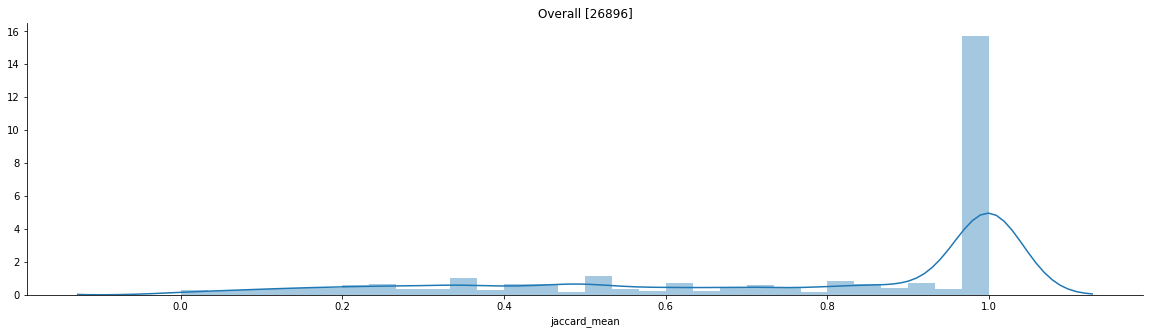

In [19]:
#@title
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.distplot(k_fold_best['jaccard_mean'], ax=ax).set_title(f"Overall [{len(k_fold_best)}]")
sns.despine()
plt.show()

## By sentiment

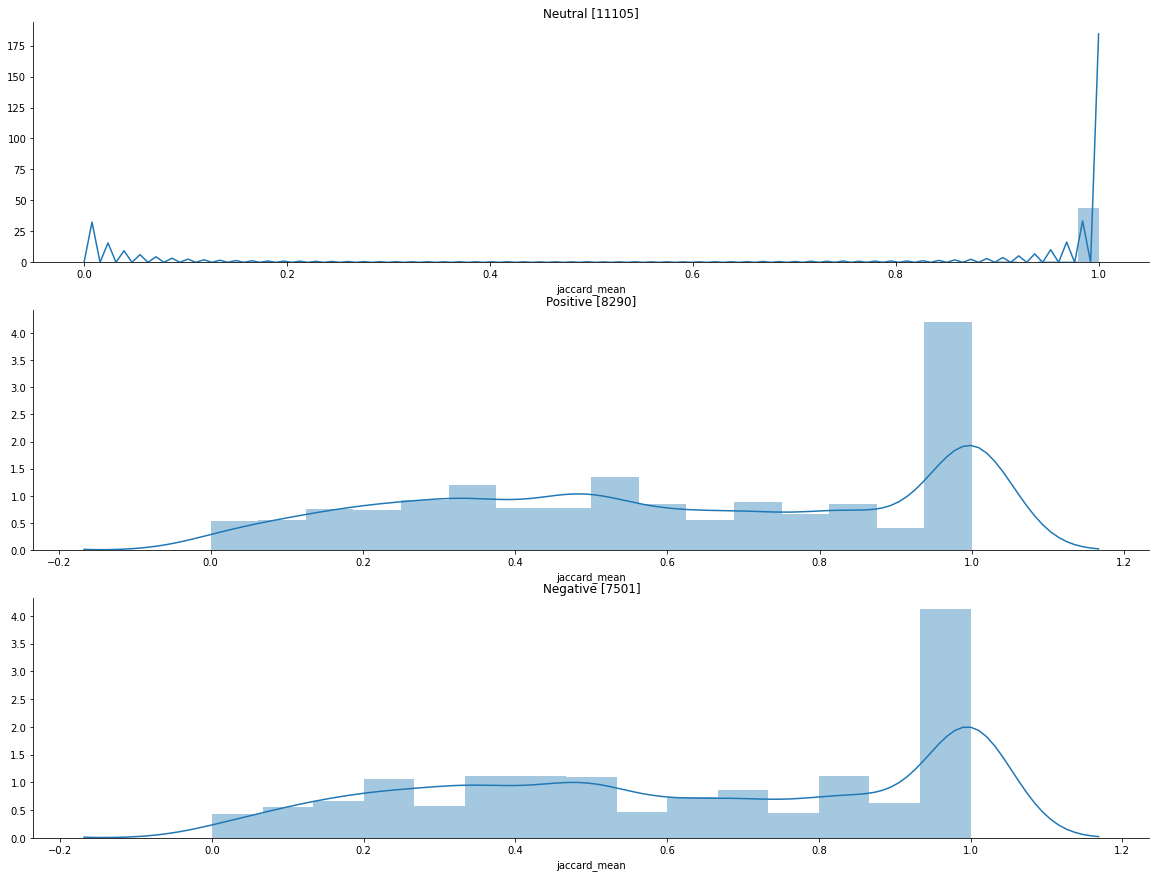

In [20]:
#@title
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=False)
sns.distplot(k_fold_best[k_fold_best['sentiment'] == 'neutral']['jaccard_mean'], ax=ax1).set_title(f"Neutral [{len(k_fold_best[k_fold_best['sentiment'] == 'neutral'])}]")
sns.distplot(k_fold_best[k_fold_best['sentiment'] == 'positive']['jaccard_mean'], ax=ax2).set_title(f"Positive [{len(k_fold_best[k_fold_best['sentiment'] == 'positive'])}]")
sns.distplot(k_fold_best[k_fold_best['sentiment'] == 'negative']['jaccard_mean'], ax=ax3).set_title(f"Negative [{len(k_fold_best[k_fold_best['sentiment'] == 'negative'])}]")
sns.despine()
plt.show()

## By text token count

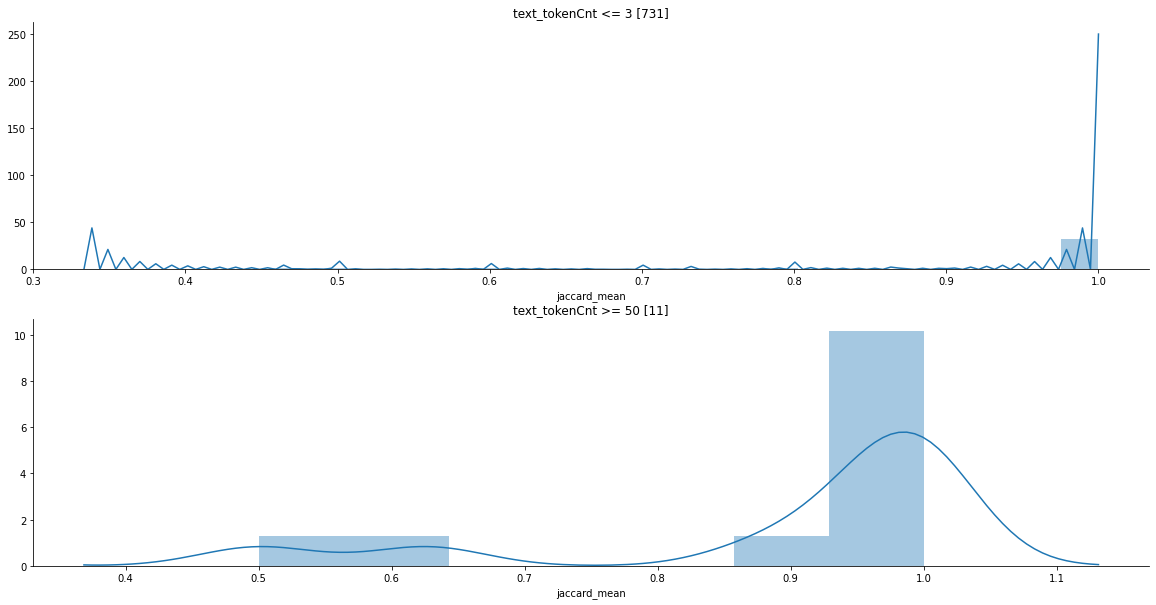

In [21]:
#@title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=False)
sns.distplot(k_fold_best[k_fold_best['text_tokenCnt'] <= 3]['jaccard_mean'], ax=ax1).set_title(f"text_tokenCnt <= 3 [{len(k_fold_best[k_fold_best['text_tokenCnt'] <= 3])}]")
sns.distplot(k_fold_best[k_fold_best['text_tokenCnt'] >= 50]['jaccard_mean'], ax=ax2).set_title(f"text_tokenCnt >= 50 [{len(k_fold_best[k_fold_best['text_tokenCnt'] >= 50])}]")
sns.despine()
plt.show()

## By selected_text token count

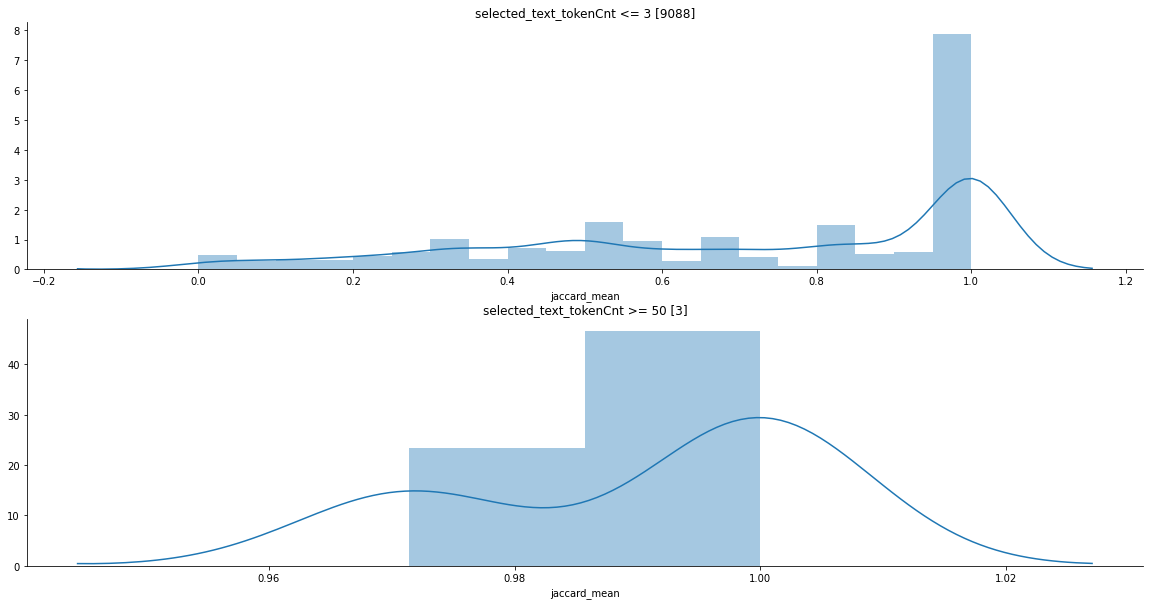

In [22]:
#@title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=False)
sns.distplot(k_fold_best[k_fold_best['selected_text_tokenCnt'] <= 3]['jaccard_mean'], ax=ax1).set_title(f"selected_text_tokenCnt <= 3 [{len(k_fold_best[k_fold_best['selected_text_tokenCnt'] <= 3])}]")
sns.distplot(k_fold_best[k_fold_best['selected_text_tokenCnt'] >= 50]['jaccard_mean'], ax=ax2).set_title(f"selected_text_tokenCnt >= 50 [{len(k_fold_best[k_fold_best['selected_text_tokenCnt'] >= 50])}]")
sns.despine()
plt.show()